# Machine Predictive Maintenance

### Results

Binary Classification Model Evaluation:

- Accuracy: 97.9% ± 0.28%
- ROC-AUC: 0.9984 ± 0.0002
- Precision: 99%
- Recall: 97%
- F1-Score: High precision and recall indicate that the model correctly identifies non-failures with minimal false positives and false negatives.

Multi-Class Classification Model Evaluation:

- Classification Report: Provided detailed metrics for each class (failure type).
- Confusion Matrix: Visualized misclassifications and helped identify areas for model improvement.

### Key Findings

- Model Performance: The binary classification model performed excellently with high accuracy and ROC-AUC, making it very effective at distinguishing between failures and non-failures. However, the multi-class classification showed some false positives and missed a few failures, indicating areas for improvement.

- Class Imbalance: Using SMOTE for balancing the class distribution helped the model better learn the minority class and improved recall.

- Feature Importance: Features like rotational speed, torque, and tool wear were identified as critical indicators of machinery failure, helping prioritize monitoring these factors for early detection.

In [1]:
import pandas as pd
import zipfile
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Extract and Load the Dataset
zip_file = 'predictive_maintenance.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

file_path = 'predictive_maintenance.csv'
data = pd.read_csv(file_path)

# Inspection: Initial Dataset
print("\nInitial Dataset Overview:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nMissing Values Summary:")
print(data.isnull().sum())


Initial Dataset Overview:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeI

In [3]:
# Data Cleaning

# Drop irrelevant columns
data_cleaned = data.drop(columns=['UDI', 'Product ID'])
print("\nDataset After Dropping Irrelevant Columns:")
print(data_cleaned.head())

# Encode 'Type' using one-hot encoding
data_cleaned = pd.get_dummies(data_cleaned, columns=['Type'], prefix='Type')
print("\nDataset After One-Hot Encoding 'Type':")
print(data_cleaned.head())

# Encode 'Failure Type' using LabelEncoder
le = LabelEncoder()
data_cleaned['Failure Type Encoded'] = le.fit_transform(data_cleaned['Failure Type'])
print("\nEncoded 'Failure Type':")
for i, label in enumerate(le.classes_):
    print(f"{i}: {label}")

# Normalize continuous features
scaler = StandardScaler()
continuous_features = [
    'Air temperature [K]', 'Process temperature [K]',
    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'
]
data_cleaned[continuous_features] = scaler.fit_transform(data_cleaned[continuous_features])
print("\nDataset After Scaling Continuous Features:")
print(data_cleaned[continuous_features].head())

# Final Inspection of Cleaned Data
print("\nCleaned Dataset Overview:")
print(data_cleaned.head())
print("\nData Types After Cleaning:")
print(data_cleaned.dtypes)


Dataset After Dropping Irrelevant Columns:
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure  

Dataset After One-Hot Encoding 'Type':
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1        

In [4]:
# Prepare Data for Training

# Separate features and targets
X = data_cleaned.drop(columns=['Target', 'Failure Type', 'Failure Type Encoded'])  # Features
y_binary = data_cleaned['Target']  # Binary target
y_multiclass = data_cleaned['Failure Type Encoded']  # Multi-class target

# Ensure all features in X are numeric
X = X.apply(pd.to_numeric)

# Split data for binary classification
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# Split data for multi-class classification
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X, y_multiclass, test_size=0.2, stratify=y_multiclass, random_state=42
)

# Inspect Class Distributions
print("\nBinary Target Distribution in Training Set:")
print(y_train_binary.value_counts(normalize=True))

print("\nMulti-Class Target Distribution in Training Set:")
print(y_train_mc.value_counts(normalize=True))


Binary Target Distribution in Training Set:
Target
0    0.966125
1    0.033875
Name: proportion, dtype: float64

Multi-Class Target Distribution in Training Set:
Failure Type Encoded
1    0.96525
0    0.01125
3    0.00950
2    0.00775
5    0.00450
4    0.00175
Name: proportion, dtype: float64


In [5]:
# Handle Class Imbalance with SMOTE

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance in the binary target
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_binary)

# Inspect Class Distribution After SMOTE
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Inspect Balanced Data
balanced_sample_df = pd.DataFrame(X_train_balanced, columns=X.columns)
balanced_sample_df['Target'] = y_train_balanced
print("\nSample of Balanced Training Data:")
print(balanced_sample_df.head())


Class Distribution After SMOTE:
Target
0    7729
1    7729
Name: count, dtype: int64

Sample of Balanced Training Data:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.998914                 0.604282               -0.460607   
1            -1.505194                -1.153260               -0.775574   
2             0.498092                 1.077466               -1.007654   
3            -0.553633                -0.139294               -0.709265   
4            -1.455112                -1.018064                1.070019   

   Torque [Nm]  Tool wear [min]    Type_H    Type_L    Type_M  Target  
0     0.718305        -0.843997 -0.330781 -1.234366  1.536207       0  
1     0.638456         0.382263 -0.330781 -1.234366  1.536207       0  
2     0.558607         0.460870 -0.330781 -1.234366  1.536207       0  
3     1.626586        -0.372359 -0.330781  0.810133 -0.650954       0  
4    -1.128202        -0.906882 -0.330781  0.810133 -0.650954       

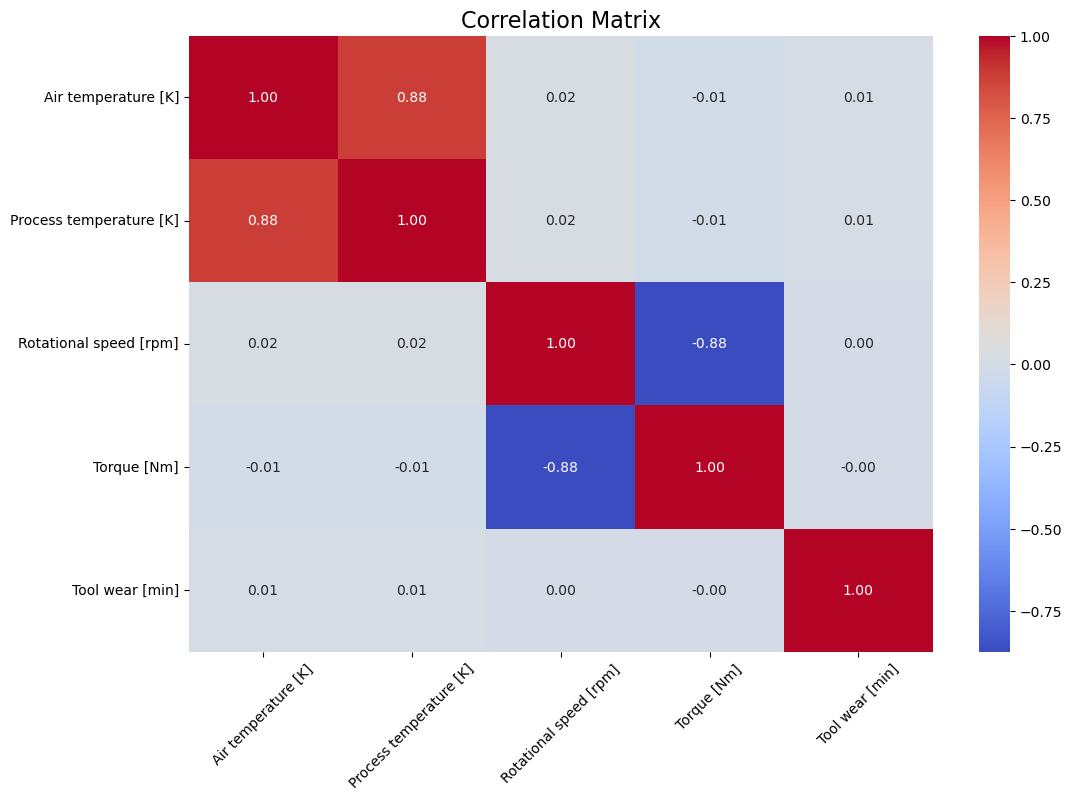

In [6]:
# Correlation and Feature Relationships

# Ensure the dataset contains only numerical columns for the correlation matrix
numerical_data = X.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()


Cross-Validation Results:
test_accuracy: 0.9790 ± 0.0028
test_roc_auc: 0.9984 ± 0.0002

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.48      0.75      0.58        68

    accuracy                           0.96      2000
   macro avg       0.73      0.86      0.78      2000
weighted avg       0.97      0.96      0.97      2000

Test ROC-AUC Score: 0.9690


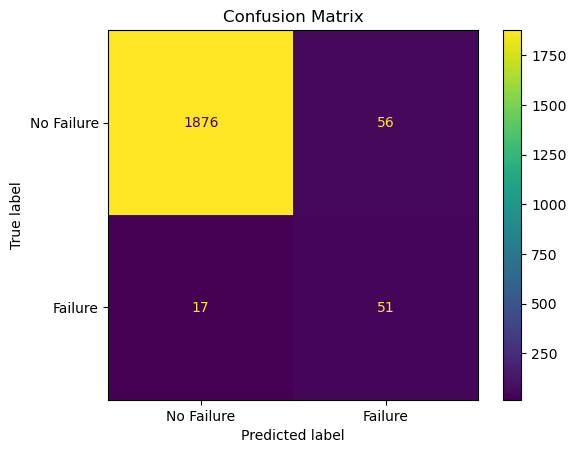

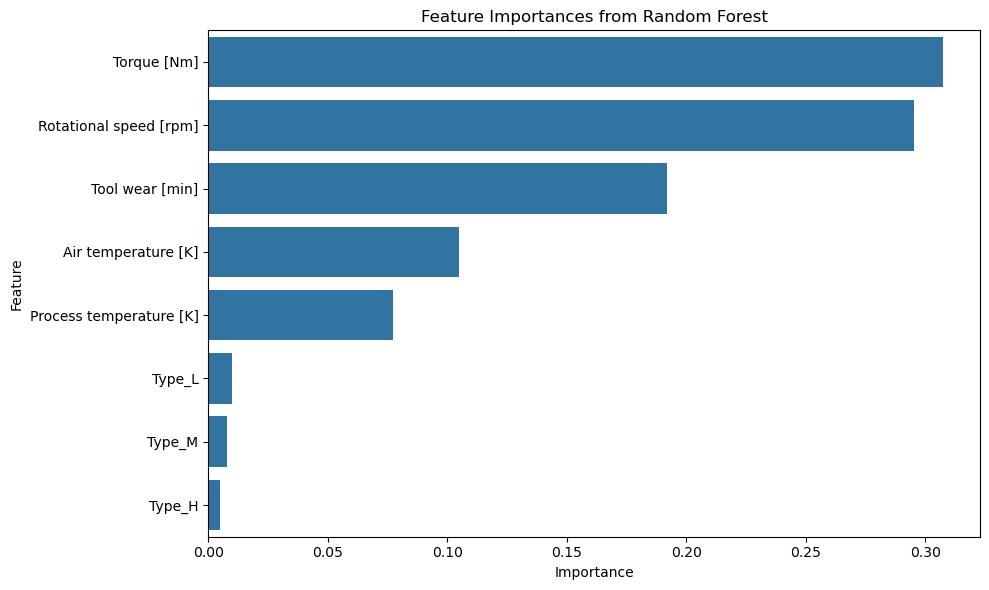

In [7]:
# Train Random Forest with Cross-Validation
rf_model = RandomForestClassifier(random_state=42)
cv_results = cross_validate(
    rf_model, X_train_balanced, y_train_balanced, cv=5, scoring=['accuracy', 'roc_auc']
)

print("\nCross-Validation Results:")
for metric, scores in cv_results.items():
    if 'test' in metric:
        print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

# Fit the model on the entire training set
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test_binary, y_pred))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['No Failure', 'Failure']).plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [8]:
# Hyperparameter Tuning

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_balanced, y_train_balanced)

# Best hyperparameters and evaluation
print("\nBest Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_rf_model.predict(X_test_scaled)
y_pred_proba_best = best_rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nBest Model Evaluation:")
print(classification_report(y_test_binary, y_pred_best))
print(f"Best Model ROC-AUC Score: {roc_auc_score(y_test_binary, y_pred_proba_best):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}

Best Model Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.45      0.75      0.56        68

    accuracy                           0.96      2000
   macro avg       0.72      0.86      0.77      2000
weighted avg       0.97      0.96      0.97      2000

Best Model ROC-AUC Score: 0.9707


In [ ]:
# Multi-Class Classification (Optional)

# Train a separate model for multi-class classification
rf_mc_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_mc_model.fit(X_train_mc, y_train_mc)

# Evaluate the multi-class model
y_pred_mc = rf_mc_model.predict(X_test_mc)
print("\nMulti-Class Classification Report:")
print(classification_report(y_test_mc, y_pred_mc))

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_mc = confusion_matrix(y_test_mc, y_pred_mc)
ConfusionMatrixDisplay(cm_mc, display_labels=le.classes_).plot(cmap='viridis')
plt.title("Confusion Matrix for Multi-Class Classification")
plt.show()